# Face Mask Detection Project

*   Dataset - https://www.kaggle.com/andrewmvd/face-mask-detection
*   Paper used for pipeline - https://www.ideas2it.com/blogs/face-mask-detector-using-deep-learning-pytorch-and-computer-vision-opencv/



In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing libraries, defining input urls

In [2]:
import numpy as np 
import pandas as pd
import os
import cv2 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25, 20)
import glob
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

#Initialization
IMAGES = "/content/drive/My Drive/images"
ANNOTATIONS = "/content/drive/My Drive/annotations"
image_directories = sorted(glob.glob(os.path.join(IMAGES,"*.png")))
classes = ["without_mask", "mask_weared_incorrect","with_mask"]
labels = []
faces = []

# Reading and resizing the images

In [3]:
def read_and_resize(filename, grayscale = False, fx= 0.5, fy=0.5):
    """
    reading data, method from the Lab
    """
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    img_result = cv2.resize(img_result, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
    return img_result

images = []
image_directories = sorted(glob.glob(os.path.join(IMAGES,"*.png")))
print(image_directories)

for idx,image in enumerate(image_directories):
  img = read_and_resize(image)
  images.append(img)
print(images[:5])

['/content/drive/My Drive/images/maksssksksss0.png', '/content/drive/My Drive/images/maksssksksss1.png', '/content/drive/My Drive/images/maksssksksss10.png', '/content/drive/My Drive/images/maksssksksss100.png', '/content/drive/My Drive/images/maksssksksss101.png', '/content/drive/My Drive/images/maksssksksss102.png', '/content/drive/My Drive/images/maksssksksss103.png', '/content/drive/My Drive/images/maksssksksss104.png', '/content/drive/My Drive/images/maksssksksss105.png', '/content/drive/My Drive/images/maksssksksss106.png', '/content/drive/My Drive/images/maksssksksss107.png', '/content/drive/My Drive/images/maksssksksss108.png', '/content/drive/My Drive/images/maksssksksss109.png', '/content/drive/My Drive/images/maksssksksss11.png', '/content/drive/My Drive/images/maksssksksss110.png', '/content/drive/My Drive/images/maksssksksss111.png', '/content/drive/My Drive/images/maksssksksss112.png', '/content/drive/My Drive/images/maksssksksss113.png', '/content/drive/My Drive/images/m

# Viewing the data

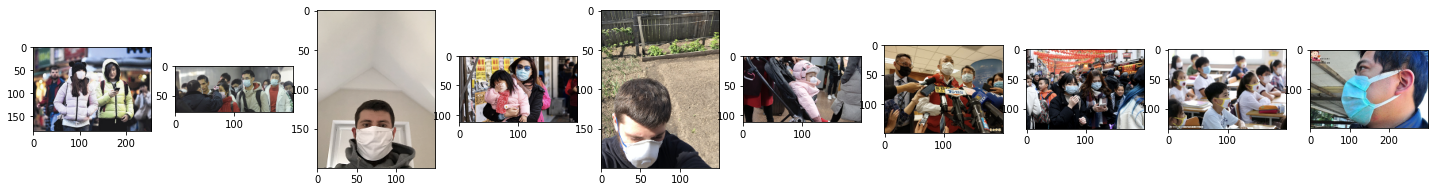

In [4]:
def showInRow(list_of_images, titles = None):
  """
  showing data, method from the Lab
  """
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
  plt.show()
showInRow(images[:10])

# Dataframe creation for the model

In [5]:
import xml.etree.ElementTree as ET

OBJECT_LEN = 116
ROW_LEN = 119

def create_dataframe(annotations, objects_len, rows_len):
  """
  creating dataframe for model training
  """
  d = {"imgs": [], "Dimensions": []}
  for i in range(1, objects_len):
    d[f'Obj {i}']=[]

  for xml_file in os.listdir(annotations):
    csv_row = []
    root = ET.parse(annotations + "/" + xml_file).getroot()
    filename = root.find("filename").text
    csv_row.append(filename)
    dimensions = root.find("size")
    height, width = dimensions[0].text, dimensions[1].text
    csv_row.append([height, width])
    objects = root.findall("object")
    for obj in objects:
      arr = []
      arr.append(obj.find("name").text)
      bndbox = obj.find("bndbox")
      for p in range(len(bndbox)): 
        arr.append(bndbox[p].text)
      csv_row.append(arr)
    for i in range(len(csv_row), rows_len):
      csv_row.append(0)
    
    for i,each in enumerate(d):
        d[each].append(csv_row[i])
  return d

In [6]:
d = create_dataframe(ANNOTATIONS, OBJECT_LEN, ROW_LEN)
dataframe = pd.DataFrame(d)
dataframe

,imgs,Dimensions,Obj 1,Obj 2,Obj 3,Obj 4,Obj 5,Obj 6,Obj 7,Obj 8,Obj 9,Obj 10,Obj 11,Obj 12,Obj 13,Obj 14,Obj 15,Obj 16,Obj 17,Obj 18,Obj 19,Obj 20,Obj 21,Obj 22,Obj 23,Obj 24,Obj 25,Obj 26,Obj 27,Obj 28,Obj 29,Obj 30,Obj 31,Obj 32,Obj 33,Obj 34,Obj 35,Obj 36,Obj 37,Obj 38,...,Obj 76,Obj 77,Obj 78,Obj 79,Obj 80,Obj 81,Obj 82,Obj 83,Obj 84,Obj 85,Obj 86,Obj 87,Obj 88,Obj 89,Obj 90,Obj 91,Obj 92,Obj 93,Obj 94,Obj 95,Obj 96,Obj 97,Obj 98,Obj 99,Obj 100,Obj 101,Obj 102,Obj 103,Obj 104,Obj 105,Obj 106,Obj 107,Obj 108,Obj 109,Obj 110,Obj 111,Obj 112,Obj 113,Obj 114,Obj 115
0,maksssksksss1.png,"[400, 156]","[with_mask, 321, 34, 354, 69]","[with_mask, 224, 38, 261, 73]","[with_mask, 299, 58, 315, 81]","[with_mask, 143, 74, 174, 115]","[with_mask, 74, 69, 95, 99]","[with_mask, 191, 67, 221, 93]","[with_mask, 21, 73, 44, 93]","[with_mask, 369, 70, 398, 99]","[without_mask, 83, 56, 111, 89]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,maksssksksss0.png,"[512, 366]","[without_mask, 79, 105, 109, 142]","[with_mask, 185, 100, 226, 144]","[without_mask, 325, 90, 360, 141]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,maksssksksss108.png,"[400, 225]","[with_mask, 155, 29, 180, 51]","[with_mask, 206, 35, 228, 58]","[with_mask, 332, 67, 346, 81]","[with_mask, 362, 68, 376, 82]","[without_mask, 267, 72, 278, 83]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,maksssksksss101.png,"[301, 400]","[with_mask, 48, 294, 164, 400]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,maksssksksss100.png,"[400, 226]","[with_mask, 189, 30, 245, 88]","[with_mask, 387, 54, 400, 75]","[with_mask, 118, 87, 163, 126]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,maksssksksss162.png,"[301, 400]","[with_mask, 86, 181, 191, 308]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
849,maksssksksss164.png,"[400, 200]","[with_mask, 12, 47, 40, 73]","[with_mask, 44, 51, 66, 75]","[with_mask, 80, 42, 99, 63]","[without_mask, 153, 39, 179, 65]","[without_mask, 203, 35, 225, 59]","[with_mask, 256, 45, 271, 63]","[with_mask, 292, 58, 311, 77]","[with_mask, 327, 64, 346, 83]","[with_mask, 361, 37, 386, 64]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
850,maksssksksss748.png,"[400, 225]","[mask_weared_incorrect, 179, 47, 283, 169]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
851,maksssksksss751.png,"[400, 267]","[with_mask, 95, 116, 135, 145]","[with_mask, 244, 59, 257, 78]","[without_mask, 249, 26, 284, 57]","[with_mask, 73, 64, 84, 80]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Face augmentation and image resizing

In [7]:
def objects_preprocessing(img, index, dataframe, resize_num):
  """
  preprocessing faces with mask and getting labels
  """
  for frame in dataframe.columns[3:]:
    if dataframe[frame][index]: 
      label = dataframe[frame][index][0]
      dataframe[frame][index][0] = dataframe[frame][index][0].replace(str(label), str(classes.index(label)))
      dataframe[frame][index] = [int(item) for item in dataframe[frame][index]]
      face = img[dataframe[frame][index][2]:dataframe[frame][index][4],dataframe[frame][index][1]:dataframe[frame][index][3]]
      if((dataframe[frame][index][3]-dataframe[frame][index][1])>40 and (dataframe[frame][index][4]-dataframe[frame][index][2])>40):
        try:
            face = cv2.resize(face, (resize_num, resize_num))
            face = img_to_array(face)
            face = preprocess_input(face)
            faces.append(face)
            labels.append(label)
            if(label=="mask_weared_incorrect"):
                faces.append(face)
                labels.append(label)
        except:
            pass
            
def images_preprocessing(img_dir):
  """
  resizes all images according to the data from xml
  """
  for index, image in enumerate(img_dir): 
    img = cv2.imread(image)
    w, h = dataframe["Dimensions"][index]
    #resizing the image
    cv2.resize(img, (int(w), int(h)))

    objects_preprocessing(img, index, dataframe, 224)

images_preprocessing(image_directories)
faces = np.array(faces, dtype="float32")
labels = np.array(labels)
labels[:10]

array(['with_mask', 'with_mask', 'with_mask', 'with_mask', 'without_mask',
       'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask'],
      dtype='<U21')

# Model creation

Source used for creating a model - https://www.mygreatlearning.com/blog/real-time-face-detection/

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
#head model which will be on the top of base
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

#headModel will be trained
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


Сonverting the labels into one-hot encoding. After that, we split the data into training and testing sets to evaluate them. Also, the next step is data augmentation which significantly increases the diversity of data available for training models, without actually collecting new data. 

In [9]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(labels)
labels = to_categorical(labels)
#splitting data into train and test, 20% per test and 80% per train 
(trainX, testX, trainY, testY) = train_test_split(faces, labels,
	test_size=0.20, stratify=labels, random_state=42)
#image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

[1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 2 1 1 2 1 2 2 1 2 1 1 1 1
 1 1 1 1 0 0 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 1 1 1 1 0 0 1 1 1 0 0 1 2 1 2 1 1 1 1 2 1 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 0 0 0 0 1 1 2 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 2 1
 2 2 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 0 0 1 1 2 2 1 1 1
 2 1 2 1 0 0 1 1 0 0 1 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


Compiling the model and train it on the augmented data.

In [10]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 1
print("Model compile.")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("Model fitting.")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Model compile.
Model fitting.
Epoch 1/20
275/275 [==============================] - 5s 18ms/step - loss: 0.4622 - accuracy: 0.7709 - val_loss: 0.4736 - val_accuracy: 0.8261
Epoch 2/20
275/275 [==============================] - 4s 15ms/step - loss: 0.3641 - accuracy: 0.8218 - val_loss: 0.3997 - val_accuracy: 0.8261
Epoch 3/20
275/275 [==============================] - 4s 15ms/step - loss: 0.3713 - accuracy: 0.8218 - val_loss: 0.3778 - val_accuracy: 0.8261
Epoch 4/20
275/275 [==============================] - 4s 15ms/step - loss: 0.3590 - accuracy: 0.8327 - val_loss: 0.3683 - val_accuracy: 0.8261
Epoch 5/20
275/275 [==============================] - 4s 15ms/step - loss: 0.3280 - accuracy: 0.8182 - val_loss: 0.3645 - val_accuracy: 0.8261
Epoch 6/20
275/275 [==============================] - 4s 15ms/step - loss: 0.3062 - accuracy: 0.8291 - val_loss: 0.3832 - val_accuracy: 0.8261
Epoch 7/20
275/275 [==============================] - 4s 15ms/step - loss: 0.3180 - accuracy: 0.8364 - val_loss:

evaluating
                       precision    recall  f1-score   support

mask_weared_incorrect       1.00      0.25      0.40         4
            with_mask       0.84      1.00      0.91        57
         without_mask       0.00      0.00      0.00         8

             accuracy                           0.84        69
            macro avg       0.61      0.42      0.44        69
         weighted avg       0.75      0.84      0.78        69

saving mask detector model...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


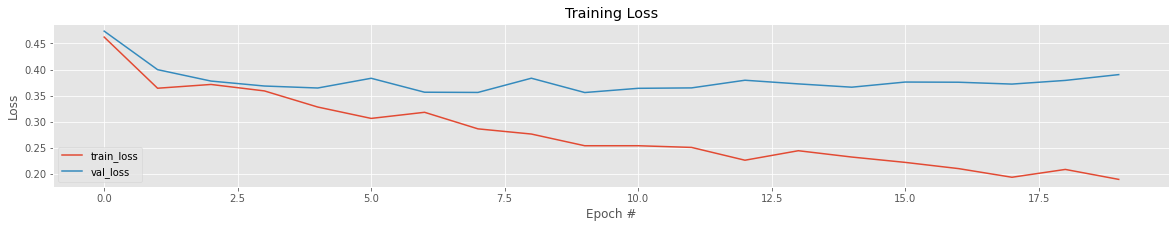

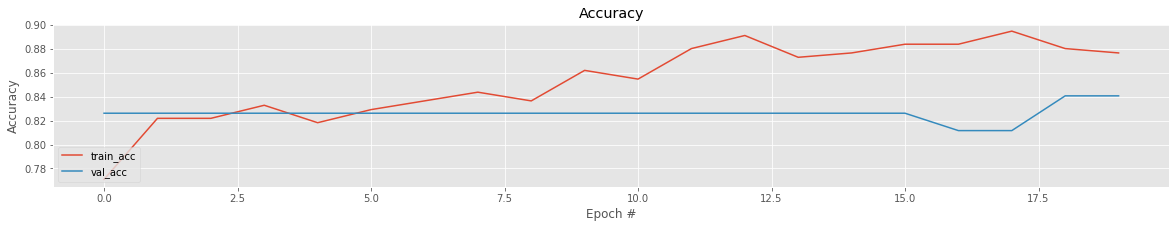

In [18]:
from sklearn.metrics import classification_report
plt.rcParams["figure.figsize"] = (20,3)
print("evaluating")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

print("saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("loss.png")
plt.show()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("accuracy.png")
plt.show()